In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from aps_ai.beamline34IDC.simulation.facade import Implementors
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_factory import focusing_optics_factory_method
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from aps_ai.beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
import beamline34IDC.optimization.common as opt_common
import beamline34IDC.optimization.movers as movers
from aps_ai.beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

In [3]:
%matplotlib inline

In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(1, 10000)
print("Default random seed is", DEFAULT_RANDOM_SEED)

Default random seed is 8184


In [6]:
work_dir = '/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/work_directory'
os.chdir(work_dir)
input_beam_path = "primary_optics_system_beam.dat"

In [7]:
fig_save_path = '/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/work_directory/figures/hkb_3/'

In [8]:
if not os.path.isdir(fig_save_path):
    print("Fig save directory does not exist. Trying to create.")
    os.mkdir(fig_save_path)

In [9]:
move_motors = ['hkb_3']

In [10]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

In [ ]:
centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
focusing_system = movers.move_motors(focusing_system, 'hkb_3', 0.0)
centroid_new, out_beam_new, *_ = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)

print(centroid, centroid_new)
_ = plot_shadow_beam_spatial_distribution(out_beam_new)

initial value is 3.0000000000000506 initial translation is -3.720558760586906
New value is 3.0000000000000506
8.961718759418355e-05 0.8929748708674413


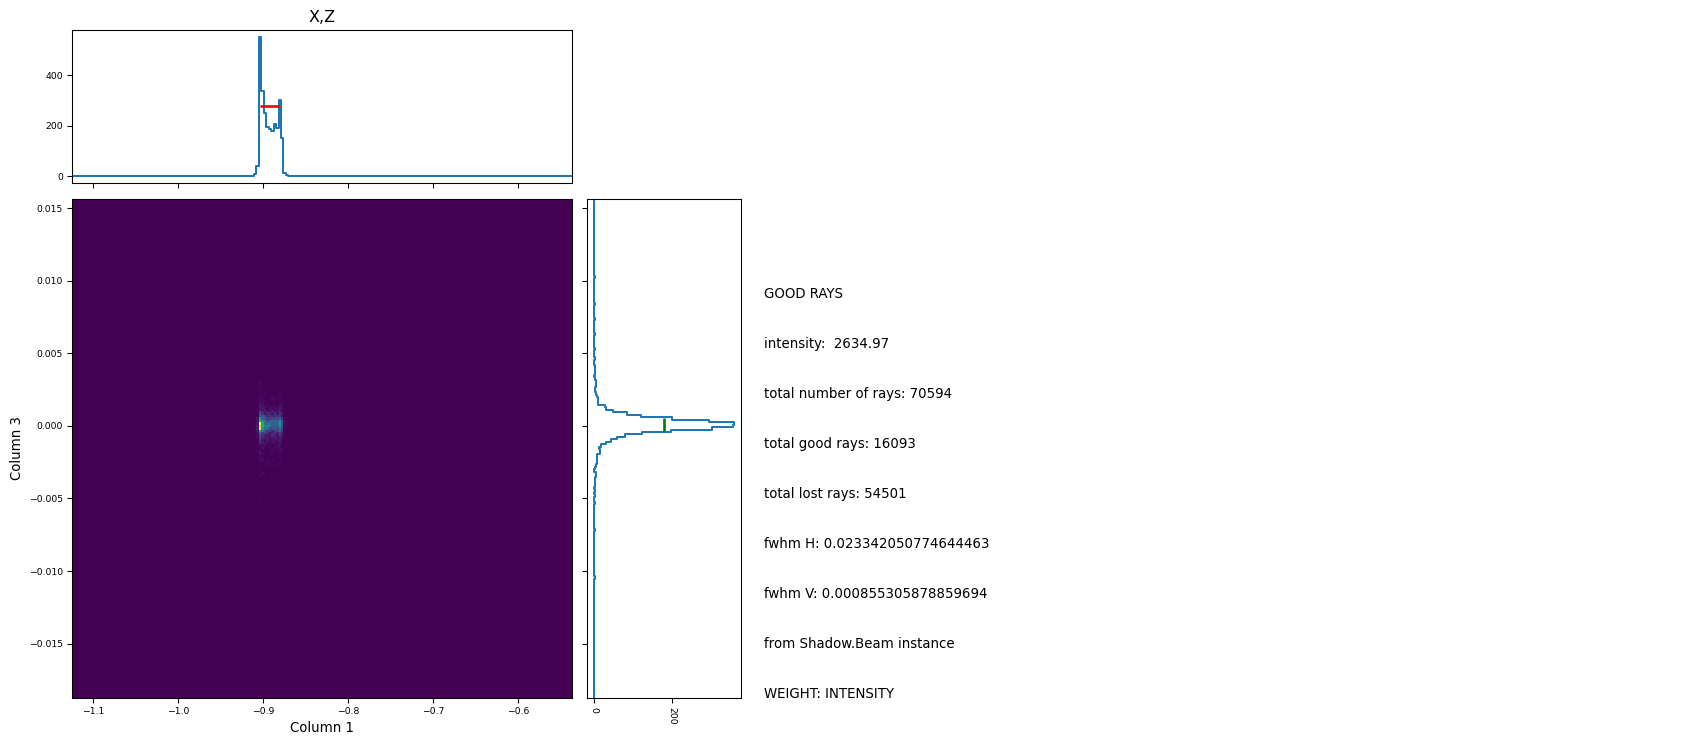

In [13]:
initial_translation = np.random.uniform(-15, 15)
initial_value = focusing_system.get_hkb_motor_3_pitch()
print("initial value is", initial_value, "initial translation is", initial_translation)
focusing_system = movers.move_motors(focusing_system, move_motors, initial_translation, movement='relative')
print("New value is", focusing_system.get_hkb_motor_3_pitch())
centroid_new, out_beam_new, *_ = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)

print(centroid, centroid_new)
_ = plot_shadow_beam_spatial_distribution(out_beam_new)

In [14]:
initial_absolute_motor_positions = initial_value + initial_translation
initial_absolute_motor_positions, initial_value, initial_translation

(-0.7205587605868553, 3.0000000000000506, -3.720558760586906)

In [15]:
focusing_system = movers.move_motors(focusing_system, move_motors, initial_absolute_motor_positions,
                                     movement='absolute')
centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
print(focusing_system.get_hkb_motor_3_pitch(), centroid)

3.0000000000000506 0.8929748708674413


In [16]:
dw.__dict__

{'_DictionaryWrapper__dictionary': {'h_sigma': 0.012112292768634313,
  'h_fwhm': 0.023342050774644463,
  'h_centroid': -0.8929748682388643,
  'v_sigma': 0.0016320605944994424,
  'v_fwhm': 0.000855305878859694,
  'v_centroid': 6.851646910090061e-05,
  'integral_intensity': 2634.9716306416503,
  'peak_intensity': 74.74580289273604,
  'gaussian_fit': {}}}

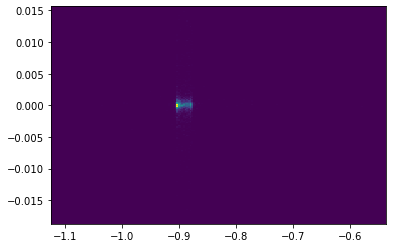

In [17]:
plt.pcolormesh(hist.hh, hist.vv, hist.data_2D)

In [20]:
initial_centroids = []
initial_out_beams = []
absolute_positions = []

start_guesses = []
overall_successes = []
final_out_beams = []
final_opt_results = []
final_centroids = []

for outer in tqdm(range(6)):
    translations = np.random.uniform(-15, 15)
    initial_absolute_motor_positions = initial_value + translations
    print("Initial motor position is", initial_absolute_motor_positions)
    absolute_positions.append(initial_absolute_motor_positions)
    
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         initial_absolute_motor_positions, movement='absolute')
    centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    initial_centroids.append(centroid)
    initial_out_beams.append(out_beam)
    
    opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                          motor_types=move_motors, 
                                          initial_motor_positions=initial_absolute_motor_positions, 
                                          random_seed=DEFAULT_RANDOM_SEED)
    
    opt_results, guesses, solution, success = opt_trial.trials(verbose=True, guess_min=-1, guess_max=1.)
    focusing_system = opt_trial.focusing_system
    
    start_guesses.append(guesses)
    overall_successes.append(success)
    centroid, out_beam, *_ = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    final_centroids.append(centroid)
    final_out_beams.append(out_beam)
    print(f'Test {outer} success {success}')
    

  0%|          | 0/6 [00:00<?, ?it/s]

Initial motor position is 12.618175479176884
motors ['hkb_3'] trans [0.] current loss 2.3029305667207427
Initial loss is 2.3029305667207427
motors ['hkb_3'] trans [-0.22309751] current loss 2.249221532516756
motors ['hkb_3'] trans [-0.23425239] current loss 2.2467603366110613
motors ['hkb_3'] trans [-0.24540726] current loss 2.2445211609421505
motors ['hkb_3'] trans [-0.26771702] current loss 2.2392578120152233
motors ['hkb_3'] trans [-0.30118164] current loss 2.230664480211119
motors ['hkb_3'] trans [-0.3681109] current loss 2.2150341861812612
motors ['hkb_3'] trans [-0.46850478] current loss 2.1913929687272145
motors ['hkb_3'] trans [-0.66929254] current loss 2.14297709048317
motors ['hkb_3'] trans [-0.97047418] current loss 2.071303916058735
motors ['hkb_3'] trans [-1.57283747] current loss 1.927222537421125
motors ['hkb_3'] trans [-2.47638239] current loss 1.7112231442736128
motors ['hkb_3'] trans [-4.28347225] current loss 1.2787333031865562
motors ['hkb_3'] trans [-6.99410703] cu

 17%|█▋        | 1/6 [01:59<09:55, 119.11s/it]

Test 0 success True
Initial motor position is 6.519287807277817
motors ['hkb_3'] trans [0.] current loss 0.8438635842612887
Initial loss is 0.8438635842612887
motors ['hkb_3'] trans [-0.51095427] current loss 0.721395617733501
motors ['hkb_3'] trans [-0.53650199] current loss 0.7152586810166047
motors ['hkb_3'] trans [-0.5620497] current loss 0.7091276410734304
motors ['hkb_3'] trans [-0.61314513] current loss 0.6968862219071439
motors ['hkb_3'] trans [-0.68978827] current loss 0.6785039172542402
motors ['hkb_3'] trans [-0.84307455] current loss 0.6417739669084577
motors ['hkb_3'] trans [-1.07300398] current loss 0.5866321406446093
motors ['hkb_3'] trans [-1.53286282] current loss 0.47636152356047196
motors ['hkb_3'] trans [-2.22265109] current loss 0.31095107989711823
motors ['hkb_3'] trans [-3.60222763] current loss 0.019952790151643304
motors ['hkb_3'] trans [-5.67159244] current loss 0.5164808827802704
motors ['hkb_3'] trans [-3.08488643] current loss 0.10414044743968778
motors ['h

 33%|███▎      | 2/6 [03:29<06:48, 102.03s/it]

Test 1 success True
Initial motor position is 9.690986953346133
motors ['hkb_3'] trans [0.] current loss 1.6033167592107727
Initial loss is 1.6033167592107727
motors ['hkb_3'] trans [0.5354573] current loss 1.7314781496270504
motors ['hkb_3'] trans [0.56223017] current loss 1.7378798738086934
motors ['hkb_3'] trans [0.50868444] current loss 1.7250654244671124
motors ['hkb_3'] trans [0.45513871] current loss 1.7122543874012672
motors ['hkb_3'] trans [0.37482011] current loss 1.6929956017453969
motors ['hkb_3'] trans [0.21418292] current loss 1.6545436967203235
motors ['hkb_3'] trans [-0.02677287] current loss 1.596911007774419
motors ['hkb_3'] trans [-0.50868444] current loss 1.4817946793877015
motors ['hkb_3'] trans [-1.2315518] current loss 1.3087037723189854
motors ['hkb_3'] trans [-2.67728652] current loss 0.9623353846240145
motors ['hkb_3'] trans [-4.8458886] current loss 0.44246803450773514
motors ['hkb_3'] trans [-9.18309277] current loss 0.5980309584210444
motors ['hkb_3'] trans

 50%|█████     | 3/6 [05:32<05:35, 111.69s/it]

Test 2 success True
Initial motor position is -4.418526471689465
motors ['hkb_3'] trans [0.] current loss 1.7818130596729582
Initial loss is 1.7818130596729582
motors ['hkb_3'] trans [-0.92194321] current loss 2.003874778054918
motors ['hkb_3'] trans [-0.96804037] current loss 2.0149840718956065
motors ['hkb_3'] trans [-0.87584605] current loss 1.9927717771231834
motors ['hkb_3'] trans [-0.78365173] current loss 1.9705730225619082
motors ['hkb_3'] trans [-0.64536025] current loss 1.9372857022955277
motors ['hkb_3'] trans [-0.36877728] current loss 1.870641216769279
motors ['hkb_3'] trans [0.04609716] current loss 1.7707066009937682
motors ['hkb_3'] trans [0.87584605] current loss 1.5710424105370493
motors ['hkb_3'] trans [2.12046938] current loss 1.2719648891493212
motors ['hkb_3'] trans [4.60971605] current loss 0.6740386783474898
motors ['hkb_3'] trans [8.34358605] current loss 0.2218247680594513
motors ['hkb_3'] trans [15.81132606] current loss 2.0104762994732015
motors ['hkb_3'] tr

 67%|██████▋   | 4/6 [07:16<03:37, 108.52s/it]

Test 3 success True
Initial motor position is 2.7740327310927055
motors ['hkb_3'] trans [0.] current loss 0.05426683581060965
Initial loss is 0.05426683581060965
motors ['hkb_3'] trans [0.61496608] current loss 0.09325121889000813
motors ['hkb_3'] trans [0.64571438] current loss 0.10062494798210295
motors ['hkb_3'] trans [0.58421777] current loss 0.08587772020571172
motors ['hkb_3'] trans [0.52272116] current loss 0.07112318341110785
motors ['hkb_3'] trans [0.43047625] current loss 0.04899854820227412
motors ['hkb_3'] trans [0.24598643] current loss 0.004734154287823565
motors ['hkb_3'] trans [-0.0307483] current loss 0.06164604233061396
motors ['hkb_3'] trans [0.17680275] current loss 0.01185159649660366
motors ['hkb_3'] trans [0.31517011] current loss 0.02134093042209979
motors ['hkb_3'] trans [0.22869051] current loss 0.0005889801981828875
motors ['hkb_3'] trans [0.21139459] current loss 0.003541959764557158
motors ['hkb_3'] trans [0.22436653] current loss 0.0004423620425462195
moto

 83%|████████▎ | 5/6 [08:18<01:31, 91.79s/it] 

Test 4 success True
Initial motor position is 1.4344983935007702
motors ['hkb_3'] trans [0.] current loss 0.37566080765265286
Initial loss is 0.37566080765265286
motors ['hkb_3'] trans [0.07840348] current loss 0.3568428535145398
motors ['hkb_3'] trans [0.08232366] current loss 0.3559032629143011
motors ['hkb_3'] trans [0.08624383] current loss 0.35496305598692574
motors ['hkb_3'] trans [0.09408418] current loss 0.35307774799047065
motors ['hkb_3'] trans [0.1058447] current loss 0.35025481547228743
motors ['hkb_3'] trans [0.12936575] current loss 0.34461133284417605
motors ['hkb_3'] trans [0.16464731] current loss 0.3361530790016945
motors ['hkb_3'] trans [0.23521045] current loss 0.3192147840645341
motors ['hkb_3'] trans [0.34105515] current loss 0.29382350377834693
motors ['hkb_3'] trans [0.55274455] current loss 0.24303072029793207
motors ['hkb_3'] trans [0.87027865] current loss 0.16684797501187593
motors ['hkb_3'] trans [1.50534686] current loss 0.014486397219438849
motors ['hkb_3

100%|██████████| 6/6 [09:47<00:00, 97.98s/it]

Test 5 success True


In [21]:
initial_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in initial_out_beams]
initial_hists, initial_dws = zip(*initial_hists_dws)

In [22]:
initial_peaks = [dw.get_parameter('peak_intensity') for dw in initial_dws]
initial_h_fwhms = [dw.get_parameter('h_fwhm') for dw in initial_dws]
initial_v_fwhms = [dw.get_parameter('v_fwhm') for dw in initial_dws]

In [23]:
final_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams]
final_hists, final_dws = zip(*final_hists_dws)

In [24]:
final_peaks = [dw.get_parameter('peak_intensity') for dw in final_dws]
final_h_fwhms = [dw.get_parameter('h_fwhm') for dw in final_dws]
final_v_fwhms = [dw.get_parameter('v_fwhm') for dw in final_dws]

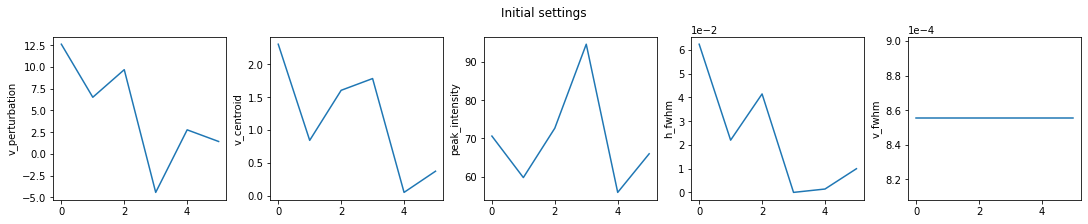

In [27]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes[0].plot(absolute_positions)
axes[0].set_ylabel('v_perturbation')

axes[1].plot(initial_centroids)
axes[1].set_ylabel('v_centroid')

axes[2].plot(initial_peaks)
axes[2].set_ylabel('peak_intensity')

axes[3].plot(initial_h_fwhms)
axes[3].set_ylabel('h_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[4].plot(initial_v_fwhms)
axes[4].set_ylabel('v_fwhm')
axes[4].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('Initial settings')
fig.savefig(f'{fig_save_path}/hkb_3_initial_metrics.png', bbox_inches='tight')

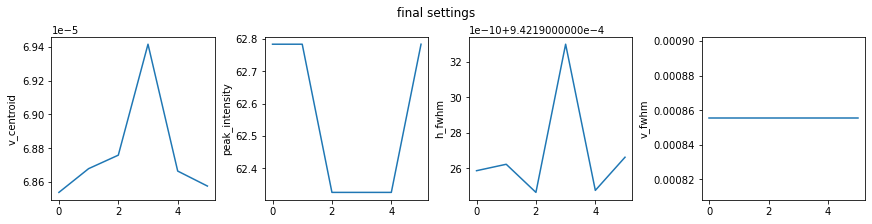

In [28]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

axes[0].plot(final_centroids)
axes[0].set_ylabel('v_centroid')

axes[1].plot(final_peaks)
axes[1].set_ylabel('peak_intensity')

axes[2].plot(final_h_fwhms)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[3].plot(final_v_fwhms)
axes[3].set_ylabel('v_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/hkb_3_final_metrics.png', bbox_inches='tight')

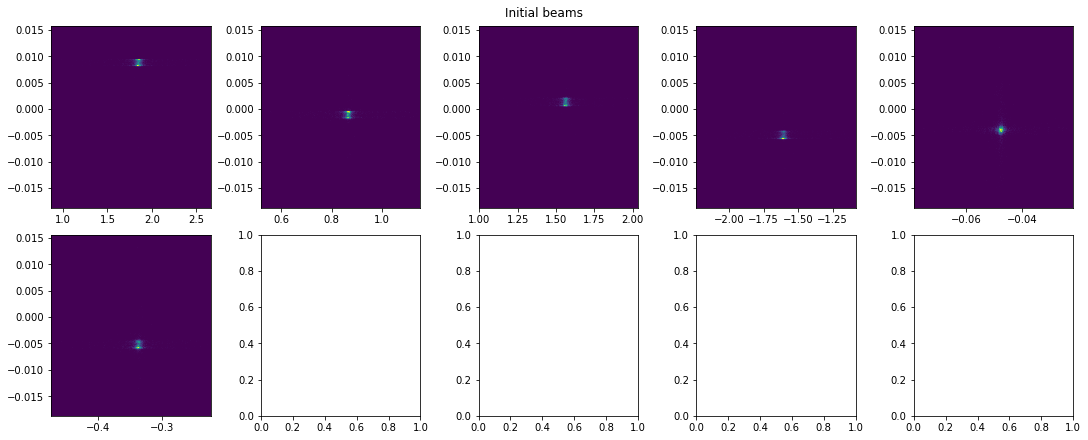

In [29]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(initial_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D.T)
    
    
fig.suptitle('Initial beams')
fig.savefig(f'{fig_save_path}/hkb_3_initial_beams.png', bbox_inches='tight')

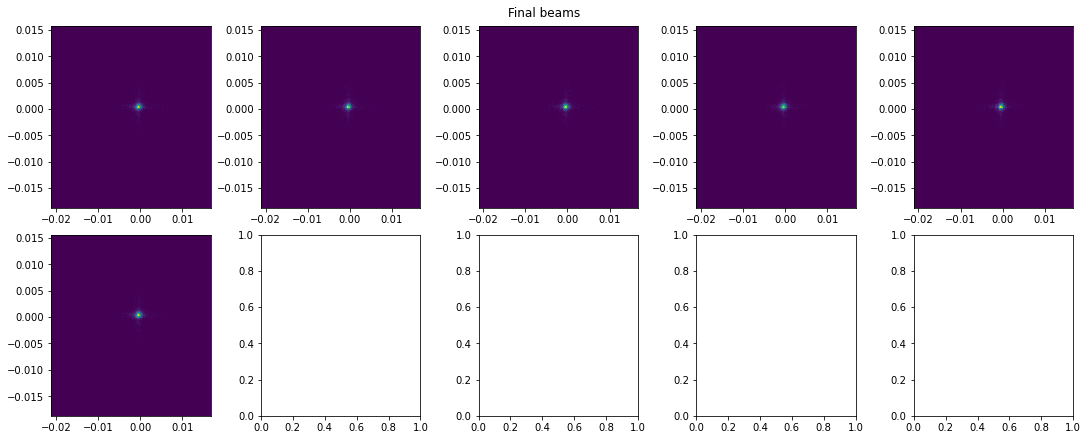

In [30]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D.T)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/hkb_3_final_beams.png', bbox_inches='tight')

In [31]:
clean_up()